In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/My Drive/사이버보안 AI 빅데이터 챌린지 2022/dataset_learn.zip (Unzipped Files)

/content/drive/.shortcut-targets-by-id/1epOBS6TJvGaDe3rc7HdSlSpLA2ioLI46/사이버보안 AI 빅데이터 챌린지 2022/dataset_learn.zip (Unzipped Files)


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from catboost import CatBoostClassifier
import glob, os
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 700)

### 1. 데이터 로드

In [ ]:
x = pd.read_csv("각종데이터셋/track_b_pre.csv").drop(["idx"],axis=1).replace(np.nan,"unknown")
payload2 = x["payload"]

In [ ]:
x2 = pd.read_csv("각종데이터셋/train_touch2.csv")
x2 = x2.astype(str)
x2["payload"] = x2["payload"].replace(np.nan, "unknown")
payload1 = x2["payload"]

In [ ]:
payload = pd.concat([payload1,payload2])
payload = pd.DataFrame(payload).set_index(np.arange(payload.shape[0]))
payload

,payload
0,......(
1,......(
2,"GET /?id=-9865%27%29%20UNION%20ALL%20SELECT%207212%2C7212%2C7212%2C7212%2C7212%2C7212%2C7212%2C7212%2C7212%2C7212%2C7212%2C7212%2C7212%2C7212%2C7212%2C7212%2C7212%2C7212%2C7212%2C7212%2C7212%2C7212%2C7212%2C7212%2C7212%2C7212%23 HTTP/1.1\r\nAccept-Encoding: gzip,deflate\r\nConnection: close\r\nAccept: */*\r\nUser-Agent: sqlmap/1.3.4#stable (http://sqlmap.org)\r\nHost: 192.168.136.132\r\nReferer: http://192.168.136.132:80\r\nCache-Control: no-cache\r\n\r\n"
3,......(
4,GET /cgi_wrapper HTTP/1.1\r\nReferer: () { _; } >_[$($())] { echo 93e4r0-CVE-2014-6278: true; echo;echo; }\r\nHost: 172.16.1.50\r\nConnection: Keep-Alive\r\nUser-Agent: () { :; }; echo 93e4r0-CVE-2014-6271: true;echo;echo;\r\n\r\nGET /contact.cgi HTTP/1.1\r\nConnection: Keep-Alive\r\nHost: 172.16.1.50\r\nReferer: () { _; } >_[$($())] { echo 93e4r0-CVE-2014-6278: true; echo;echo; }\r\nUser-Agent: () { :; }; echo 93e4r0-CVE-2014-6271: true;echo;echo;\r\n\r\nGET /count.cgi HTTP/1.1\r\nUser-Agent: () { :; }; echo 93e4r0-CVE-2014-6271: true;echo;echo;\r\nConnection: Keep-Alive\r\nHost: 172.16.1.50\r\nReferer: () { _; } >_[$($())] { echo 93e4r0-CVE-2014-6278: true; echo;echo; }\r\n\r\nGET /def...
...,...
59995,"GET /index.JSP HTTP/1.1\r\nConnection: Keep-Alive\r\nHost: 172.16.1.50\r\nContent-Length: 714\r\nUser-Agent: Mozilla/5.00 (Nikto/2.1.6) (Evasions:None) (Test:006993)\r\nContent-Type: application/x-www-form-urlencoded\r\n\r\n<?xml version=\""1.0\"" encoding=\""utf-8\""?><!DOCTYPE test [ <!ENTITY xxe SYSTEM \""/etc/passwd\""> ]><amfx ver=\""3\"" xmlns=\""http://www.macromedia.com/2005/amfx\""><body><object type=\""flex.messaging.messages.CommandMessage\""><traits><string>body</string><string>clientId</string><string>correlationId</string><string>destination</string><string>headers</string><string>messageId</string><string>operation</string><string>timestamp</string><string>timeToLive</string></traits>..."
59996,"GET /?id=user%22%20UNION%20ALL%20SELECT%20NULL%2CNULL%2CNULL%2CNULL%2CNULL%2CNULL%2CNULL%2CNULL%2CNULL--%20yzCW HTTP/1.1\r\nAccept-Encoding: gzip,deflate\r\nConnection: close\r\nAccept: */*\r\nUser-Agent: sqlmap/1.3.4#stable (http://sqlmap.org)\r\nHost: 192.168.136.132\r\nReferer: http://192.168.136.132:80\r\nCache-Control: no-cache\r\n\r\n"
59997,......(
59998,"t/encrypted;protocol=\""application/HTTP-SPNEGO-session-encrypted\"";boundary=\""Encrypted Boundary\""\r\nUser-Agent: Microsoft WinRM Client\r\nContent-Length: 1962\r\nHost: 172.16.1.71:5985\r\n\r\n--Encrypted Boundary\r\nContent-Type: application/HTTP-SPNEGO-session-encrypted\r\nOriginalContent: type=application/soap+xml;charset=UTF-8;Length=1707\r\n--Encrypted Boundary\r\nContent-Type: application/octet-stream\r\n...........s..d......Oo.hD*.........\r...B.K..lB.cF.4{.@.a......./..Q.tz..s..eGp.c..>..|...as..K(/\n.*0....p..]...Q-......PB..4..:...A....>.H.\\.~+..5-.N.ep...kvN......0..>..5.^.@.s......k?.ty.z./s%.KEsO.....S'<..t.R.-.K.........C.m+.....=....T...D..<..../I...CJ.sl..~F..M......D....."


### 2. 파생변수 생성 

In [ ]:
# ip 주소 쪼개서 파생변수 생성

x["s_ip1"] = x["s_ip"].str.split(".").str.get(0)
x["s_ip2"] = x["s_ip"].str.split(".").str.get(1)
x["s_ip3"] = x["s_ip"].str.split(".").str.get(2)
x["s_ip4"] = x["s_ip"].str.split(".").str.get(3)

x["d_ip1"] = x["d_ip"].str.split(".").str.get(0)
x["d_ip2"] = x["d_ip"].str.split(".").str.get(1)
x["d_ip3"] = x["d_ip"].str.split(".").str.get(2)
x["d_ip4"] = x["d_ip"].str.split(".").str.get(3)

In [ ]:
# ip 주소 host id, network id 분류 파생변수 생성

x["s_host_ip"]= x["s_ip2"].astype("str") + " " + x["s_ip3"].astype("str") + " " + x["s_ip4"].astype("str")
x["d_host_ip"]= x["d_ip2"].astype("str") + " " + x["d_ip3"].astype("str") + " " + x["d_ip4"].astype("str")
x = x.rename(columns = {"s_ip1" : "s_network_id", "d_ip1" : "d_network_id"})
x

,s_ip,s_port,d_ip,d_port,protocol,payload,risk,s_network_id,s_ip2,s_ip3,s_ip4,d_network_id,d_ip2,d_ip3,d_ip4,s_host_ip,d_host_ip
0,194.45.133.205,3389,223.78.72.205,39034,TCP( 6 ),.........4.........,3,194,45,133,205,223,78,72,205,45 133 205,78 72 205
1,41.122.42.110,3389,56.139.100.11,43746,TCP( 6 ),".........4.............A...M..a..-3.].n....b..[z.^w...!...=... ......m..Td...g..r....C`q.....n../..................0...0..........a....i_.O...Ae..0\r..*.H..\r.....0.1.0...U...\rWIN-webServer0..\r210722081657Z.\r220121081657Z0.1.0...U...\rWIN-webServer0..\""0\r..*.H..\r..........0..\n......E..\r{$.E..T..O.F3}f.5K.....|..<gl..D@W....._.>S...)\"".....O..w..e........\r.5...*..n..V\nNd.!..1..Y...?..8.|.h..*]..:...........i..I.&.nV.%..b(/.Rh-....J|S0@...^.qzY_|..,.UB../-'.&)......,+d...TV..P.x^,...j9M.x.3..E.N.>..@..}...ZBSVp.&..I.....HHP......._j_........$0\""0...U.%..0\n..+.......0...U.......00\r..*.H..\r.........._........8..'Qs.gT...M4......DsH......QlL....au...q.a.U.,H)..~_%8N.v...r..@.7Y.c....",3,41,122,42,110,56,139,100,11,122 42 110,139 100 11
2,114.223.201.8,43330,97.209.139.46,80,TCP( 6 ),OPTIONS / HTTP/1.1\r\nHost: 172.16.1.50\r\nUser-Agent: Mozilla/5.0 (compatible; Nmap Scripting Engine; https://nmap.org/book/nse.html)\r\nConnection: close\r\nAccess-Control-Request-Method: DELETE\r\nOrigin: example.com\r\n\r\n,1,114,223,201,8,97,209,139,46,223 201 8,209 139 46
3,174.134.63.141,80,155.18.68.107,9155,TCP( 6 ),"HTTP/1.1 200 OK\r\nCache-Control: private\r\nContent-Type: text/html\r\nServer: Microsoft-IIS/7.5\r\nX-Powered-By: ASP.NET\r\nDate: Fri, 23 Jul 2021 06:52:48 GMT\r\nConnection: close\r\n\r\n<font face=arial size=-2 color=red>Please create your target directory for copying files as it does not exist. </font><font face=arial size=-1 color=red>D:\\hshome\\masterhr\\masterhr.com\\<BR></font>\n<html>\n<style>\n<!--\nA:link {font-style: text-decoration: none; color: #c8c8c8}\nA:visited {font-style: text-decoration: none; color: #777777}\nA:active {font-style: text-decoration: none; color: #ff8300}\nA:hover {font-style: text-decoration: cursor: hand; color: #ff8300}\n*..{scrollbar-base-color:#7...",1,174,134,63,141,155,18,68,107,134 63 141,18 68 107
4,9.100.170.255,59254,169.9.189.151,80,TCP,"GET /?id=-7327%27%29%20AS%20pCEU%20WHERE%209573%3D9573%20UNION%20ALL%20SELECT%209573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%23 HTTP/1.1\r\nAccept-Encoding: gzip,deflate\r\nConnection: close\r\nAccept: */*\r\nUser-Agent: sqlmap/1.3.4#stable (http://sqlmap.org)\r\nHost: 192.168.136.132\r\nReferer: http://192.168.136.132:80\r\nCache-Control: no-cache\r\n\r\n",1,9,100,170,255,169,9,189,151,100 170 255,9 189 151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,152.44.75.69,20688,116.45.96.46,80,TCP( 6 ),"GET /index.JSP HTTP/1.1\r\nConnection: Keep-Alive\r\nHost: 172.16.1.50\r\nContent-Length: 714\r\nUser-Agent: Mozilla/5.00 (Nikto/2.1.6) (Evasions:None) (Test:006993)\r\nContent-Type: application/x-www-form-urlencoded\r\n\r\n<?xml version=\""1.0\"" encoding=\""utf-8\""?><!DOCTYPE test [ <!ENTITY xxe SYSTEM \""/etc/passwd\""> ]><amfx ver=\""3\"" xmlns=\""http://www.macromedia.com/2005/amfx\""><body><object type=\""flex.messaging.messages.CommandMessage\""><traits><string>body</string><string>clientId</string><string>correlationId</string><string>destination</string><string>headers</string><string>messageId</string><string>operation</string><string>timestamp</string><string>timeToLive</string></traits>...",1,152,44,75,69,116,45,96,46,44 75 69,45 96 46
9996,72.218.153.161,48932,65.236.97.204,80,TCP,"GET /?id=user%22%20UNION%20ALL%20SELECT%20NULL%2CNULL%2CNULL%2CNULL%2CNULL%2CNULL%2CNULL%2CNULL%2CNULL--%20yzCW HTTP/1.1\r\nAccept-Encoding: gzip,deflate\r\nConnection: close\r\nAccept: */*\r\nUser-Agent: sqlmap/1.3.4#stable (http://sqlmap.org)\r\nHost: 192.168.136.132\r\nReferer: http://192.168.136.132:80\r\nCache-Control: no-cache\r\n\r\n",1,72

In [ ]:
# IP 헤더에 따른 클래스 파생변수 생성

x.iloc[:,7:15] = x.iloc[:,7:15].astype("int") # 변수 타입 정수로 설정

x["s_ip_class"] = np.nan
x["d_ip_class"] = np.nan

x["s_ip_class"] = np.where(x["s_network_id"] <= 127 , "A", x["s_ip_class"])
x["s_ip_class"] = np.where((x["s_network_id"] >= 128) & (x["s_network_id"] <= 191) , "B", x["s_ip_class"])
x["s_ip_class"] = np.where((x["s_network_id"] >= 192) & (x["s_network_id"] <= 223) , "C", x["s_ip_class"])
x["s_ip_class"] = np.where((x["s_network_id"] >= 224) , "D or E", x["s_ip_class"])

x["d_ip_class"] = np.where(x["d_network_id"] <= 127 , "A", x["d_ip_class"])
x["d_ip_class"] = np.where((x["d_network_id"] >= 128) & (x["d_network_id"] <= 191) , "B", x["d_ip_class"])
x["d_ip_class"] = np.where((x["d_network_id"] >= 192) & (x["d_network_id"] <= 223) , "C", x["d_ip_class"])
x["d_ip_class"] = np.where((x["d_network_id"] >= 224) , "D or E", x["d_ip_class"])

In [ ]:
# 포트번호에 따른 클래스 파생변수 생성

x["s_port_class"] = np.nan
x["d_port_class"] = np.nan

x["s_port_class"] = np.where(x["s_port"] <= 1023 , "well-known", x["s_port_class"])
x["s_port_class"] = np.where((x["s_port"] >= 1024) & (x["s_port"] <= 49151) , "registered", x["s_port_class"])
x["s_port_class"] = np.where((x["s_port"] >= 49152) & (x["s_port"] <= 65535) , "dynamic", x["s_port_class"])

x["d_port_class"] = np.where(x["d_port"] <= 1023 , "well-known", x["d_port_class"])
x["d_port_class"] = np.where((x["d_port"] >= 1024) & (x["d_port"] <= 49151) , "registered", x["d_port_class"])
x["d_port_class"] = np.where((x["d_port"] >= 49152) & (x["d_port"] <= 65535) , "dynamic", x["d_port_class"])


#### TfidfVectorizer의 tokenizer인자로 사용될 lemmatization 어근 변환 함수를 설정. 

In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

# 입력으로 들어온 token단어들에 대해서 lemmatization 어근 변환. 
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

# TfidfVectorizer 객체 생성 시 tokenizer인자로 해당 함수를 설정하여 lemmatization 적용
# 입력으로 문장을 받아서 stop words 제거-> 소문자 변환 -> 단어 토큰화 -> lemmatization 어근 변환. 
def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [ ]:
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

#### TF-IDF 기반 Vectorization 적용 및 KMeans 군집화 수행. 
* Stemming과 Lemmatization 같은 어근 변환은 TfidfVectorizer에서 직접 지원하진 않으나 tokenizer 파라미터에 커스텀 어근 변환 함수를 적용하여 어근 변환을 수행할 수 있음
* TfidfVectorizer 생성자의 tokenizer인자로 위에서 생성 LemNormalize 함수 설정.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english' , \
                             ngram_range=(1,2), min_df=0.05, max_df=0.85 )

tfidf = tfidf_vect.fit(payload["payload"])
tfidf.get_feature_names()
#opinion_text 컬럼값으로 feature vectorization 수행
feature_vect = tfidf_vect.transform(payload["payload"])

In [ ]:
import joblib

#joblib.dump(feature_vect, "model_pkl/tfidf_vect2.pkl")

['model_pkl/tfidf_vect2.pkl']

In [ ]:
# tfidf 행렬 -> 데이터프레임 변환

aa = pd.DataFrame(feature_vect.toarray(), columns = tfidf_vect.get_feature_names())
aa

,0,0 color,0px,0px 2px,0px 4px,0px 5px,0px 6px,0px abc,0rgba1741741831,0rgba1741741831 100,...,working,working properly,wsmanpsversion713,wsmanpsversion713 http11rnconnection,wwwexamplecom,wwwexamplecom send,xhtml,xhtml 11en,youve,youve seen
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.119062,0.119081,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.cluster import KMeans

# 43개 집합으로 군집화 수행. 예제를 위해 동일한 클러스터링 결과 도출용 random_state=999
km_cluster = KMeans(n_clusters = 50, max_iter=10000, random_state=999)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

In [ ]:
x['cluster_label'] = cluster_label[50000:]
x2["cluster_label"] = cluster_label[:50000]

#### 공격여부 변수 생성

In [ ]:
import re
import urllib.parse
import pprint

In [ ]:
idxs = x.index
payloads = x["payload"]

In [ ]:
# Reconnaissance
def is_xml_rpc(s: str):
    # https://nitesculucian.github.io/2019/07/01/exploiting-the-xmlrpc-php-on-all-wordpress-versions/
    return "<methodCall>" in s

def is_shell_shock(s: str):
    # https://github.com/sullo/nikto/blob/master/program/plugins/nikto_shellshock.plugin
    # https://kinggod-daddong.tistory.com/4
    return "() { :; }; echo" in s

# Execution
def is_sql_injection(s: str):  # Initial Access -> Exploit Public-Facing Application
    dmls = ["insert", "update", "delete", "select", "INSERT", "UPDATE", "DELETE", "SELECT"]
    return int(any(list(map(lambda d: d in s, dmls))))

def is_malicious_execution(s: str):
    return "/etc/passwd" in s

def is_xss_attack(s: str):
    return "<script>" in s

def is_directory_traversal(s: str):
    # https://www.cvedetails.com/cve/CVE-2005-1198/
    return "apexec.pl" in s

# Post
def is_web_shell(s: str):  # Persistence
    # https://github.com/Yara-Rules/rules/blob/master/webshells/WShell_THOR_Webshells.yar
    return "aspydrv" in s

def is_shell_file(s: str):  # Persistence
    # https://lannstark.tistory.com/8
    # https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/Content-Disposition
    return "shell" in s

In [ ]:
methods = ["GET", "HEAD", "POST", "PUT", "DELETE", "CONNECT", "OPTIONS", "TRACE"]
d_keys = ["has_xml_rpc", "has_sql_injection", "has_shell_shock", "has_malicious_execution", "has_xss_attack", "has_directory_traversal", "has_web_shell", "has_shell_file"]
d_values = [0,0,0,0,0,0,0,0]

In [ ]:
dicts = dict()

for idx in tqdm(range(x.shape[0])):
    payload = payloads[idx]
    # print(f"{idx}\n{payload}\n")
    d = dict(zip(d_keys, d_values))
    
    if payload is np.nan:
        dicts.update({idx: d})
        continue
    elif "DOCTYPE" in payload:
        d.update({"has_html": 1})
        dicts.update({idx : d})
        continue

    fields = re.split("\\r\\n|\\\\r\\\\n", payload)
    for field in fields:
        if not field:
            if d:
                dicts.update({idx: d})
            else:
                d = dict(zip(d_keys, d_values))
        #print(field)
        field_name, *field_value = field.split(": ")
        if is_xml_rpc(field_name):
            d.update({d_keys[0]: 1})
        elif "Content-Disposition" in field_name and any(map(lambda v: is_shell_file(v), field_value)):
            d.update({d_keys[7]: 1})
        elif "User-Agent" in field_name and any(map(lambda v: is_shell_shock(v), field_value)):
            d.update({d_keys[2]: 1})
        elif any(m in field_name for m in methods): # for start line of the HTTP message
            # if is_xss_attack(field_name):
            #     d.update({d_keys[4]: 1})
            #     continue
            if is_directory_traversal(field_name):
                d.update({d_keys[5]: 1})
                continue

            parse_result = urllib.parse.urlparse(field_name)
            query = parse_result.query
            queries = urllib.parse.parse_qs(query)
            for param_name, param_value in queries.items():
                if any(map(lambda v: is_sql_injection(v), param_value)):
                    d.update({d_keys[1]: 1}) 
                elif any(map(lambda v: is_malicious_execution(v), param_value)):
                    d.update({d_keys[3]: 1})
                elif is_xss_attack(field_name):
                    d.update({d_keys[4]: 1})
        # elif any(map(lambda v: is_shell_shock(v), field_value)):
        #     d.update({d_keys[2]: 1})
        elif any(map(lambda v: is_web_shell(v), field_value)):
            d.update({d_keys[6]: 1})
        
    value = dicts.get(idx)
    if value is None:
        dicts.update({idx: d})

#print()
#pprint.pprint(dicts)

100%|██████████| 10000/10000 [00:01<00:00, 9492.66it/s]


In [ ]:
dl = {'has_sql_injection' : [],
      'has_shell_shock' : [],
      'has_malicious_execution' : [],
      'has_xss_attack' : [],
      'has_web_shell' : [],
      'has_xml_rpc': [],
      'has_directory_traversal': [],
      'has_shell_file': []
      }
dl

{'has_sql_injection': [],
 'has_shell_shock': [],
 'has_malicious_execution': [],
 'has_xss_attack': [],
 'has_web_shell': [],
 'has_xml_rpc': [],
 'has_directory_traversal': [],
 'has_shell_file': []}

In [ ]:
# 여러 딕셔너리로 저장된 값을 하나의 딕셔너리로 저장

for i in tqdm(range(len(dicts))):
    dl["has_sql_injection"].append(dicts[i]["has_sql_injection"])
    dl["has_shell_shock"].append(dicts[i]["has_shell_shock"])
    dl["has_malicious_execution"].append(dicts[i]["has_malicious_execution"])
    dl["has_xss_attack"].append(dicts[i]["has_xss_attack"])
    dl["has_web_shell"].append(dicts[i]["has_web_shell"])
    dl["has_xml_rpc"].append(dicts[i]["has_xml_rpc"])
    dl["has_directory_traversal"].append(dicts[i]["has_directory_traversal"])
    dl["has_shell_file"].append(dicts[i]["has_shell_file"])


100%|██████████| 10000/10000 [00:00<00:00, 611717.76it/s]


In [ ]:
# 페이로드 기반 공격 여부 변수 생성

x["has_sql_injection"] = dl["has_sql_injection"]
x["has_shell_shock"] = dl["has_shell_shock"]
x["has_malicious_execution"] = dl["has_malicious_execution"]
x["has_xss_attack"] = dl["has_xss_attack"]
x["has_web_shell"] = dl["has_web_shell"]
x["has_xml_rpc"] = dl["has_xml_rpc"]
x["has_directory_traversal"] = dl["has_directory_traversal"]
x["has_shell_file"] = dl["has_shell_file"]

In [ ]:
# 설명변수 모두 범주형 변수로 변환(수치형으로 보이는 자료 없음)
x = x.astype(str)
x2 = x2.astype(str)

In [ ]:
ip = pd.read_csv("각종데이터셋/ip_location_0-9999.csv")[["s_country_code","d_country_code"]]
x[["s_country_code", "d_country_code"]] = ip[["s_country_code","d_country_code"]]
x[["s_country_code", "d_country_code"]] = x[["s_country_code", "d_country_code"]].replace(np.nan,"unknown")
x

,s_ip,s_port,d_ip,d_port,protocol,payload,risk,s_network_id,s_ip2,s_ip3,...,has_sql_injection,has_shell_shock,has_malicious_execution,has_xss_attack,has_web_shell,has_xml_rpc,has_directory_traversal,has_shell_file,s_country_code,d_country_code
0,194.45.133.205,3389,223.78.72.205,39034,TCP( 6 ),.........4.........,3,194,45,133,...,0,0,0,0,0,0,0,0,NL,CN
1,41.122.42.110,3389,56.139.100.11,43746,TCP( 6 ),".........4.............A...M..a..-3.].n....b..[z.^w...!...=... ......m..Td...g..r....C`q.....n../..................0...0..........a....i_.O...Ae..0\r..*.H..\r.....0.1.0...U...\rWIN-webServer0..\r210722081657Z.\r220121081657Z0.1.0...U...\rWIN-webServer0..\""0\r..*.H..\r..........0..\n......E..\r{$.E..T..O.F3}f.5K.....|..<gl..D@W....._.>S...)\"".....O..w..e........\r.5...*..n..V\nNd.!..1..Y...?..8.|.h..*]..:...........i..I.&.nV.%..b(/.Rh-....J|S0@...^.qzY_|..,.UB../-'.&)......,+d...TV..P.x^,...j9M.x.3..E.N.>..@..}...ZBSVp.&..I.....HHP......._j_........$0\""0...U.%..0\n..+.......0...U.......00\r..*.H..\r.........._........8..'Qs.gT...M4......DsH......QlL....au...q.a.U.,H)..~_%8N.v...r..@.7Y.c....",3,41,122,42,...,0,0,0,0,0,0,0,0,ZA,US
2,114.223.201.8,43330,97.209.139.46,80,TCP( 6 ),OPTIONS / HTTP/1.1\r\nHost: 172.16.1.50\r\nUser-Agent: Mozilla/5.0 (compatible; Nmap Scripting Engine; https://nmap.org/book/nse.html)\r\nConnection: close\r\nAccess-Control-Request-Method: DELETE\r\nOrigin: example.com\r\n\r\n,1,114,223,201,...,0,0,0,0,0,0,0,0,CN,US
3,174.134.63.141,80,155.18.68.107,9155,TCP( 6 ),"HTTP/1.1 200 OK\r\nCache-Control: private\r\nContent-Type: text/html\r\nServer: Microsoft-IIS/7.5\r\nX-Powered-By: ASP.NET\r\nDate: Fri, 23 Jul 2021 06:52:48 GMT\r\nConnection: close\r\n\r\n<font face=arial size=-2 color=red>Please create your target directory for copying files as it does not exist. </font><font face=arial size=-1 color=red>D:\\hshome\\masterhr\\masterhr.com\\<BR></font>\n<html>\n<style>\n<!--\nA:link {font-style: text-decoration: none; color: #c8c8c8}\nA:visited {font-style: text-decoration: none; color: #777777}\nA:active {font-style: text-decoration: none; color: #ff8300}\nA:hover {font-style: text-decoration: cursor: hand; color: #ff8300}\n*..{scrollbar-base-color:#7...",1,174,134,63,...,0,0,0,0,1,0,0,0,US,US
4,9.100.170.255,59254,169.9.189.151,80,TCP,"GET /?id=-7327%27%29%20AS%20pCEU%20WHERE%209573%3D9573%20UNION%20ALL%20SELECT%209573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%2C9573%23 HTTP/1.1\r\nAccept-Encoding: gzip,deflate\r\nConnection: close\r\nAccept: */*\r\nUser-Agent: sqlmap/1.3.4#stable (http://sqlmap.org)\r\nHost: 192.168.136.132\r\nReferer: http://192.168.136.132:80\r\nCache-Control: no-cache\r\n\r\n",1,9,100,170,...,1,0,0,0,0,0,0,0,US,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,152.44.75.69,20688,116.45.96.46,80,TCP( 6 ),"GET /index.JSP HTTP/1.1\r\nConnection: Keep-Alive\r\nHost: 172.16.1.50\r\nContent-Length: 714\r\nUser-Agent: Mozilla/5.00 (Nikto/2.1.6) (Evasions:None) (Test:006993)\r\nContent-Type: application/x-www-form-urlencoded\r\n\r\n<?xml version=\""1.0\"" encoding=\""utf-8\""?><!DOCTYPE test [ <!ENTITY xxe SYSTEM \""/etc/passwd\""> ]><amfx ver=\""3\"" xmlns=\""http://www.macromedia.com/2005/amfx\""><body><object type=\""flex.messaging.messages.CommandMessage\""><traits><string>body</string><string>clientId</string><string>correlationId</string><string>destination</string><string>headers</string><string>messageId</string><string>operation</string><string>timestamp</string><string>timeToLive</string></traits>...",1,152,44,75,...,0,0,0,0,0,0,0,0,US,KR
9996,72.218.153.161,48932,65.236.97.204,80,TCP,"GET /?id=user%22%20UNION%20ALL%20SELECT%20NULL%2CNULL%2CNULL%2CNULL%2CNULL%2CNULL%2CNULL%2CNULL%2CNULL--%20yzCW HTTP/1.1\r\nAccept-Encoding: gzip,deflate\r\nConnection: close\r\nAccept: */*\r\nUser-Agent: sqlmap/1.3.4#stable (http://sqlmap.org)\r\nHost: 192.168.136.132\r\nReferer: http://1

In [ ]:
# 임시 저장

#x.to_csv("train_touch.csv", index = False)

In [ ]:
x["attack_pattern"] = x["has_sql_injection"] + x["has_shell_shock"] + x["has_malicious_execution"] + x["has_xss_attack"] + x["has_web_shell"] + x["has_xml_rpc"] + x["has_directory_traversal"] + x["has_shell_file"]

In [ ]:
x2["attack_pattern"] = x2["has_sql_injection"] + x2["has_shell_shock"] + x2["has_malicious_execution"] + x2["has_xss_attack"] + x2["has_web_shell"] + x2["has_xml_rpc"] + x2["has_directory_traversal"] + x2["has_shell_file"]

### 3. 만든 변수를 가지고 간단한 모델링(catboost)

In [ ]:
x = x.drop(columns = ["s_ip","d_ip","payload"], axis = 1)
x2 = x2.drop(columns = ["s_ip","d_ip","payload"],axis = 1)

In [ ]:
y = pd.read_csv("각종데이터셋/track_b_learn_label.csv").drop(columns = ["idx"],axis =1)

In [ ]:
cat_features = [ col for col in x.columns if x[col].dtypes == "object"]
cat_features

In [ ]:
cat_features

['s_port',
 'd_port',
 'protocol',
 'risk',
 's_network_id',
 's_ip2',
 's_ip3',
 's_ip4',
 'd_network_id',
 'd_ip2',
 'd_ip3',
 'd_ip4',
 's_host_ip',
 'd_host_ip',
 's_ip_class',
 'd_ip_class',
 's_port_class',
 'd_port_class',
 'cluster_label',
 'has_sql_injection',
 'has_shell_shock',
 'has_malicious_execution',
 'has_xss_attack',
 'has_web_shell',
 'has_xml_rpc',
 'has_directory_traversal',
 'has_shell_file',
 's_country_code',
 'd_country_code',
 'attack_pattern']

In [ ]:
from sklearn.model_selection import train_test_split, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=999)

scores = []


models = []
for tri, vai in cv.split(x2):
    print("="*50)
    preds = []

    model = CatBoostClassifier(iterations=2000,random_state=999,eval_metric="TotalF1",cat_features=cat_features)
    model.fit(x2.iloc[tri], y.iloc[tri], 
            eval_set=[(x2.iloc[vai], y.iloc[vai])], 
            early_stopping_rounds=50 ,
            verbose = 100
        )
    
    models.append(model)
    scores.append(model.get_best_score()["validation"]["TotalF1"])
    if False:
        break    

Learning rate set to 0.089202
0:	learn: 0.9817879	test: 0.9802679	best: 0.9802679 (0)	total: 938ms	remaining: 31m 15s
100:	learn: 0.9920432	test: 0.9925793	best: 0.9928879 (75)	total: 1m 19s	remaining: 24m 56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.992892828
bestIteration = 141

Shrink model to first 142 iterations.
Learning rate set to 0.089202
0:	learn: 0.9794813	test: 0.9822844	best: 0.9822844 (0)	total: 835ms	remaining: 27m 48s
100:	learn: 0.9917246	test: 0.9923777	best: 0.9923777 (89)	total: 1m 14s	remaining: 23m 14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9930835565
bestIteration = 128

Shrink model to first 129 iterations.
Learning rate set to 0.089202
0:	learn: 0.9810440	test: 0.9809431	best: 0.9809431 (0)	total: 839ms	remaining: 27m 56s
100:	learn: 0.9920682	test: 0.9928054	best: 0.9932116 (91)	total: 1m 15s	remaining: 23m 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9932116073
bestIteration = 

Text(0.5, 1.0, 'Feature Importance')

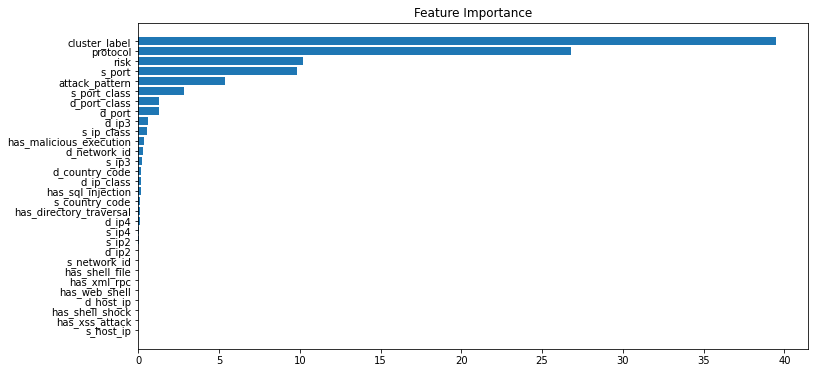

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x.columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
x3 = x2.drop(columns = ["s_host_ip","d_host_ip"],axis = 1)
x3

,s_port,d_port,protocol,risk,s_network_id,s_ip2,s_ip3,s_ip4,d_network_id,d_ip2,...,has_shell_shock,has_malicious_execution,has_xss_attack,has_web_shell,has_xml_rpc,has_directory_traversal,has_shell_file,s_country_code,d_country_code,attack_pattern
0,47760,42718,TCP,medium,210,248,110,200,144,82,...,0,0,0,0,0,0,0,JP,GB,00000000
1,47760,39548,TCP,medium,172,116,62,150,38,29,...,0,0,0,0,0,0,0,US,US,00000000
2,60390,80,TCP,low,15,164,135,69,37,154,...,0,0,0,0,0,0,0,KR,TR,10000000
3,47760,37816,TCP,medium,84,12,150,116,64,89,...,0,0,0,0,0,0,0,GB,US,00000000
4,53040,80,TCP( 6 ),low,95,42,196,145,17,75,...,1,0,0,0,0,0,0,BG,ES,01000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,47760,44958,TCP,medium,128,194,190,9,90,155,...,0,0,0,0,0,0,0,US,GB,00000000
49996,47760,33206,TCP,medium,58,186,58,89,202,147,...,0,0,0,0,0,0,0,VN,IN,00000000
49997,47760,55558,TCP,medium,75,241,39,21,184,243,...,0,0,0,0,0,0,0,US,US,00000000
49998,47760,39450,TCP,medium,146,204,158,13,96,204,...,0,0,0,0,0,0,0,US,US,00000000


In [ ]:
cat_features2 = [ col for col in x3.columns if x3[col].dtypes == "object"]
cat_features2

In [ ]:
from sklearn.model_selection import train_test_split, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=999)

scores = []


models = []
for tri, vai in cv.split(x3):
    print("="*50)
    preds = []

    model2 = CatBoostClassifier(iterations=2000,random_state=999,eval_metric="TotalF1",cat_features=cat_features2)
    model2.fit(x3.iloc[tri], y.iloc[tri], 
            eval_set=[(x3.iloc[vai], y.iloc[vai])], 
            early_stopping_rounds=50 ,
            verbose = 100
        )
    
    models.append(model2)
    scores.append(model2.get_best_score()["validation"]["TotalF1"])
    if False:
        break    

Learning rate set to 0.089202
0:	learn: 0.9796701	test: 0.9789743	best: 0.9789743 (0)	total: 740ms	remaining: 24m 39s
100:	learn: 0.9920248	test: 0.9929908	best: 0.9929908 (94)	total: 1m 9s	remaining: 21m 55s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9929907552
bestIteration = 94

Shrink model to first 95 iterations.
Learning rate set to 0.089202
0:	learn: 0.9780541	test: 0.9809757	best: 0.9809757 (0)	total: 693ms	remaining: 23m 5s
100:	learn: 0.9919713	test: 0.9925006	best: 0.9927004 (88)	total: 1m 8s	remaining: 21m 21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9927004324
bestIteration = 88

Shrink model to first 89 iterations.
Learning rate set to 0.089202
0:	learn: 0.9790387	test: 0.9809193	best: 0.9809193 (0)	total: 712ms	remaining: 23m 42s
100:	learn: 0.9919694	test: 0.9920067	best: 0.9925885 (56)	total: 1m 6s	remaining: 20m 49s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9925884898
bestIteration = 56

Shr

Text(0.5, 1.0, 'Feature Importance')

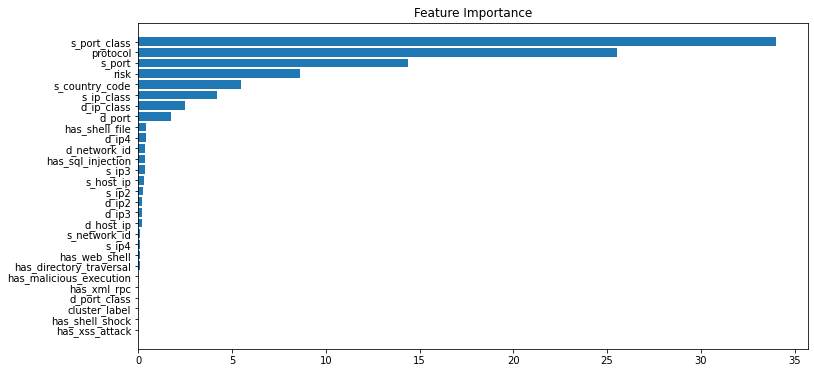

In [ ]:
feature_importance = model2.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x.columns)[sorted_idx])
plt.title('Feature Importance')

### 제출본

In [ ]:
model.predict(x)

array([['3_post'],
       ['3_post'],
       ['1_reconnaissance'],
       ...,
       ['4_unknown'],
       ['3_post'],
       ['1_reconnaissance']], dtype=object)

In [ ]:
df = pd.DataFrame(model.predict(x)).rename(columns = {0:"class"})
df = df.reset_index()
df = df.rename(columns = {0:"class","index" : "idx"})
df

,idx,class
0,0,3_post
1,1,3_post
2,2,1_reconnaissance
3,3,4_unknown
4,4,2_exploit
...,...,...
9995,9995,1_reconnaissance
9996,9996,2_exploit
9997,9997,4_unknown
9998,9998,3_post


In [ ]:
df = pd.DataFrame(model2.predict(x.drop(columns = ["s_host_ip","d_host_ip"],axis = 1))).rename(columns = {0:"class"})
df = df.reset_index()
df = df.rename(columns = {0:"class","index" : "idx"})
df

,idx,class
0,0,3_post
1,1,3_post
2,2,1_reconnaissance
3,3,4_unknown
4,4,2_exploit
...,...,...
9995,9995,2_exploit
9996,9996,2_exploit
9997,9997,4_unknown
9998,9998,3_post


In [ ]:
df.to_csv("제출3_drop1.csv",index = False)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, f1_score
y_pred= model.predict(x2)
print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))
print(precision_score(y_pred, y, average = "macro"))
print(f1_score(y_pred, y, average = "macro"))

                  precision    recall  f1-score   support

1_reconnaissance       0.97      0.97      0.97      2503
       2_exploit       0.99      1.00      1.00     19690
          3_post       1.00      1.00      1.00     11718
       4_unknown       1.00      1.00      1.00     16089

        accuracy                           1.00     50000
       macro avg       0.99      0.99      0.99     50000
    weighted avg       1.00      1.00      1.00     50000

[[ 2424    73     6     0]
 [   51 19617    19     3]
 [   14    26 11670     8]
 [    8    12     4 16065]]
0.989785611066438
0.9901389332719277


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, f1_score
y_pred2= model2.predict(x3)
print(classification_report(y, y_pred2))
print(confusion_matrix(y, y_pred2))
print(precision_score(y_pred2, y, average = "macro"))
print(f1_score(y_pred2, y, average = "macro"))

                  precision    recall  f1-score   support

1_reconnaissance       0.96      0.96      0.96      2503
       2_exploit       0.99      1.00      0.99     19690
          3_post       1.00      1.00      1.00     11718
       4_unknown       1.00      1.00      1.00     16089

        accuracy                           0.99     50000
       macro avg       0.99      0.99      0.99     50000
    weighted avg       0.99      0.99      0.99     50000

[[ 2404    93     6     0]
 [   61 19608    19     2]
 [   20    17 11671    10]
 [   12    11     5 16061]]
0.9876329174180968
0.98797964169695
